# Churn Prediction with PySpark using MLlib and ML Packages


>PYSPARK_DRIVER_PYTHON=ipython PYSPARK_DRIVER_PYTHON_OPTS=notebook /path/to/bin/pyspark --packages com.databricks:spark-csv_2.10:1.3.0 --master local[*]

In [1]:
# Disable warnings, set Matplotlib inline plotting and load Pandas package
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import pandas as pd
pd.options.display.mpl_style = 'default'

## Fetching and Importing Churn Data



In [2]:
CV_data = sqlContext.read.load('/Users/snerur/insy5376/churn-bigml-80.csv', 
                          format='com.databricks.spark.csv', 
                          header='true', 
                          inferSchema='true')

final_test_data = sqlContext.read.load('/Users/snerur/insy5376/churn-bigml-20.csv', 
                          format='com.databricks.spark.csv', 
                          header='true', 
                          inferSchema='true')
CV_data.cache()
CV_data.printSchema()
#CV_data.dtypes

root
 |-- State: string (nullable = true)
 |-- Account length: integer (nullable = true)
 |-- Area code: integer (nullable = true)
 |-- International plan: string (nullable = true)
 |-- Voice mail plan: string (nullable = true)
 |-- Number vmail messages: integer (nullable = true)
 |-- Total day minutes: double (nullable = true)
 |-- Total day calls: integer (nullable = true)
 |-- Total day charge: double (nullable = true)
 |-- Total eve minutes: double (nullable = true)
 |-- Total eve calls: integer (nullable = true)
 |-- Total eve charge: double (nullable = true)
 |-- Total night minutes: double (nullable = true)
 |-- Total night calls: integer (nullable = true)
 |-- Total night charge: double (nullable = true)
 |-- Total intl minutes: double (nullable = true)
 |-- Total intl calls: integer (nullable = true)
 |-- Total intl charge: double (nullable = true)
 |-- Customer service calls: integer (nullable = true)
 |-- Churn: boolean (nullable = true)



By taking 5 rows of the CV_data variable and generating a Pandas DataFrame with them, we can get a display of what the rows look like. We're using Pandas instead of the Spark _DataFrame.show()_ function because it creates a prettier print.

In [3]:
pd.DataFrame(CV_data.take(5), columns=CV_data.columns)

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


## Summary Statistics

 

In [4]:
CV_data.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
State,2666,None,None,AK,WY
Account length,2666,100.62040510127532,39.56397365334985,1,243
Area code,2666,437.43885971492875,42.521018019427174,408,510
International plan,2666,None,None,No,Yes
Voice mail plan,2666,None,None,No,Yes
Number vmail messages,2666,8.021755438859715,13.61227701829193,0,50
Total day minutes,2666,179.48162040510135,54.21035022086982,0.0,350.8
Total day calls,2666,100.31020255063765,19.988162186059512,0,160
Total day charge,2666,30.512404351087813,9.215732907163497,0.0,59.64


## Correlations and Data Preparation



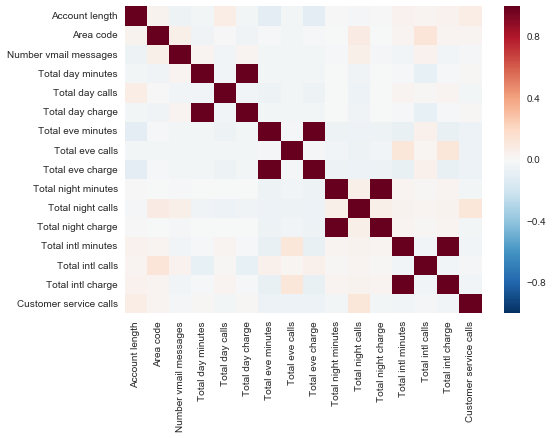

In [5]:
numeric_features = [t[0] for t in CV_data.dtypes if t[1] == 'int' or t[1] == 'double']

import seaborn as sns
sampled_data = CV_data.select(numeric_features).sample(False, 0.10).toPandas()
corr = sampled_data.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)


In [6]:
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import UserDefinedFunction

temp_data = CV_data
binary_map = {'Yes':1.0, 'No':0.0, True:1.0, False:0.0}
toNum = UserDefinedFunction(lambda k: binary_map[k], DoubleType())
final_CV_data = CV_data.drop('State').drop('Area code') \
    .drop('Total day charge').drop('Total eve charge') \
    .drop('Total night charge').drop('Total intl charge')\
    .withColumn('Churn', toNum(CV_data['Churn'])) \
    .withColumn('International plan', toNum(CV_data['International plan'])) \
    .withColumn('Voice mail plan', toNum(CV_data['Voice mail plan'])).cache() 

final_test_data = final_test_data.drop('State').drop('Area code') \
    .drop('Total day charge').drop('Total eve charge') \
    .drop('Total night charge').drop('Total intl charge') \
    .withColumn('Churn', toNum(final_test_data['Churn'])) \
    .withColumn('International plan', toNum(final_test_data['International plan'])) \
    .withColumn('Voice mail plan', toNum(final_test_data['Voice mail plan'])).cache()


Let's take a quick look at the resulting data set.

In [7]:
final_CV_data.toPandas()[:5]

,Account length,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total eve minutes,Total eve calls,Total night minutes,Total night calls,Total intl minutes,Total intl calls,Customer service calls,Churn
0,128,0,1,25,265.1,110,197.4,99,244.7,91,10.0,3,1,0
1,107,0,1,26,161.6,123,195.5,103,254.4,103,13.7,3,1,0
2,137,0,0,0,243.4,114,121.2,110,162.6,104,12.2,5,0,0
3,84,1,0,0,299.4,71,61.9,88,196.9,89,6.6,7,2,0
4,75,1,0,0,166.7,113,148.3,122,186.9,121,10.1,3,3,0


## Using the Spark MLlib Package



In [8]:
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.tree import DecisionTree

def labelData(data):
    # label: row[end], features: row[0:end-1]
    return data.rdd.map(lambda row: LabeledPoint(row[-1], row[:-1]))


training_data, testing_data = labelData(final_CV_data).randomSplit([0.8, 0.2])

model = DecisionTree.trainClassifier(training_data, numClasses=2, maxDepth=2,
                                     categoricalFeaturesInfo={1:2, 2:2},
                                     impurity='gini', maxBins=32)

print model.toDebugString()

DecisionTreeModel classifier of depth 2 with 7 nodes
  If (feature 12 <= 3.0)
   If (feature 4 <= 261.9)
    Predict: 0.0
   Else (feature 4 > 261.9)
    Predict: 1.0
  Else (feature 12 > 3.0)
   If (feature 4 <= 143.5)
    Predict: 1.0
   Else (feature 4 > 143.5)
    Predict: 0.0



In [9]:
print 'Feature 12:', CV_data.columns[12]
print 'Feature 4: ', CV_data.columns[4]

Feature 12: Total night minutes
Feature 4:  Voice mail plan


### Model Evaluation



In [10]:
from pyspark.mllib.evaluation import MulticlassMetrics

def getPredictionsLabels(model, test_data):
    predictions = model.predict(test_data.map(lambda r: r.features))
    return predictions.zip(test_data.map(lambda r: r.label))

def printMetrics(predictions_and_labels):
    metrics = MulticlassMetrics(predictions_and_labels)
    print 'Precision of True ', metrics.precision(1)
    print 'Precision of False', metrics.precision(0)
    print 'Recall of True    ', metrics.recall(1)
    print 'Recall of False   ', metrics.recall(0)
    print 'F-1 Score         ', metrics.fMeasure()
    print 'Confusion Matrix\n', metrics.confusionMatrix().toArray()

predictions_and_labels = getPredictionsLabels(model, testing_data)

printMetrics(predictions_and_labels)

Precision of True  0.692307692308
Precision of False 0.901030927835
Recall of True     0.428571428571
Recall of False    0.9646799117
F-1 Score          0.880819366853
Confusion Matrix
[[ 437.   16.]
 [  48.   36.]]


In [11]:
final_CV_data.groupby('Churn').count().toPandas()

,Churn,count
0,0,2278
1,1,388


### Stratified Sampling



In [12]:
stratified_CV_data = final_CV_data.sampleBy('Churn', fractions={0: 388./2278, 1: 1.0}).cache()

stratified_CV_data.groupby('Churn').count().toPandas()

,Churn,count
0,0,413
1,1,388


Let's build a new model using the evenly distributed data set and see how it performs.

In [13]:
training_data, testing_data = labelData(stratified_CV_data).randomSplit([0.8, 0.2])

model = DecisionTree.trainClassifier(training_data, numClasses=2, maxDepth=2,
                                     categoricalFeaturesInfo={1:2, 2:2},
                                     impurity='gini', maxBins=32)

predictions_and_labels = getPredictionsLabels(model, testing_data)
printMetrics(predictions_and_labels)

Precision of True  0.875
Precision of False 0.745283018868
Recall of True     0.644736842105
Recall of False    0.918604651163
F-1 Score          0.79012345679
Confusion Matrix
[[ 79.   7.]
 [ 27.  49.]]


With these new recall values, we can see that the stratified data was helpful in building a less biased model, which will ultimately provide more generalized and robust predictions.